## GRU

               date area  pm10  pm2.5
0  2022-12-31 23:00  강남구 57.00  44.00
1  2022-12-31 23:00  강동구 68.00  55.00
2  2022-12-31 23:00  강북구 59.00  42.00
3  2022-12-31 23:00  강서구 62.00  40.00
4  2022-12-31 23:00  관악구 57.00  38.00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227759 entries, 0 to 227758
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    227759 non-null  object 
 1   area    227759 non-null  object 
 2   pm10    222843 non-null  float64
 3   pm2.5   223512 non-null  float64
dtypes: float64(2), object(2)
memory usage: 7.0+ MB
None
Epoch 1/10
2772/2772 [==============================] - 16s 5ms/step - loss: 2.5918e-04 - val_loss: 2.3624e-04
Epoch 2/10
2772/2772 [==============================] - 15s 5ms/step - loss: 1.9490e-04 - val_loss: 2.4629e-04
Epoch 3/10
2772/2772 [==============================] - 14s 5ms/step - loss: 1.9051e-04 - val_loss: 2.3598e-04
Epoch 4/10
2772/2772 [======================

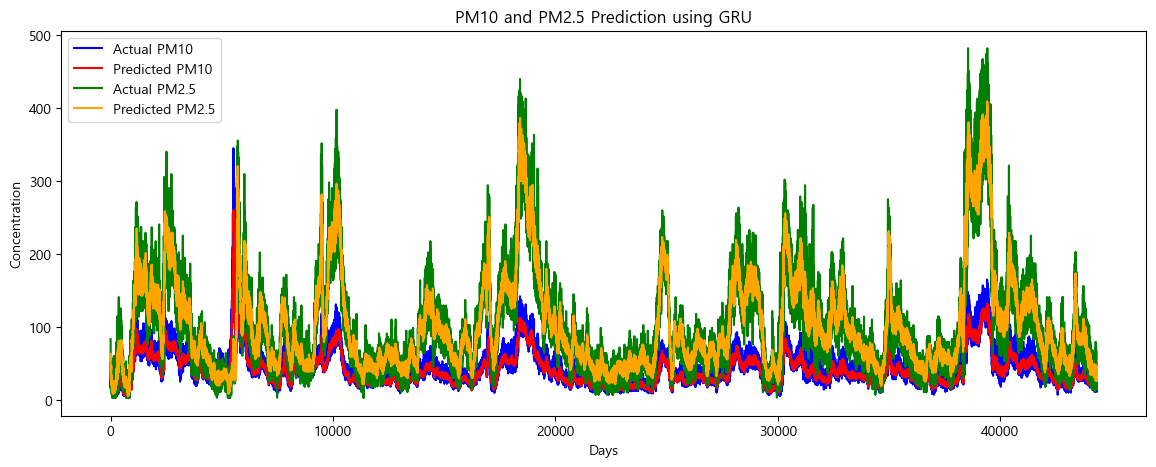

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler

# 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
pd.options.display.float_format = '{:.2f}'.format


# 1. 데이터 로드
df = pd.read_csv('./dataset/seoul_pm10.csv', encoding='cp949')

# 2. 데이터 확인
print(df.head())
print(df.info())

# NaN 값 확인 및 처리
df = df.dropna()

# 3. 데이터 전처리
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df = pd.get_dummies(df, columns=['area'])

# 4. 데이터셋 생성
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['pm10', 'pm2.5', 'hour', 'day_of_week', 'month']])

look_back = 10
X, y_pm10, y_pm25 = [], [], []
for i in range(len(scaled_data) - look_back):
    X.append(scaled_data[i:i + look_back])
    y_pm10.append(scaled_data[i + look_back, 0])
    y_pm25.append(scaled_data[i + look_back, 1])
X, y_pm10, y_pm25 = np.array(X), np.array(y_pm10), np.array(y_pm25)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train_pm10, y_test_pm10 = y_pm10[:train_size], y_pm10[train_size:]
y_train_pm25, y_test_pm25 = y_pm25[:train_size], y_pm25[train_size:]

# 5. 데이터 예측 모델 구성 (PM10)
model_pm10 = Sequential([
    GRU(64, input_shape=(look_back, X.shape[2])),
    Dense(1)
])

# 6. 모델 학습 (PM10)
model_pm10.compile(optimizer='adam', loss='mse')
history_pm10 = model_pm10.fit(X_train, y_train_pm10, epochs=10, batch_size=64, validation_data=(X_test, y_test_pm10))

# 7. 예측 (PM10)
predictions_pm10 = model_pm10.predict(X_test)
predictions_pm10 = scaler.inverse_transform(np.concatenate((predictions_pm10, np.zeros((predictions_pm10.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

# 8. 실제 값 복원 (PM10)
actual_values_pm10 = scaler.inverse_transform(np.concatenate((y_test_pm10.reshape(-1, 1), np.zeros((y_test_pm10.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

# 5. 데이터 예측 모델 구성 (PM2.5)
model_pm25 = Sequential([
    GRU(64, input_shape=(look_back, X.shape[2])),
    Dense(1)
])

# 6. 모델 학습 (PM2.5)
model_pm25.compile(optimizer='adam', loss='mse')
history_pm25 = model_pm25.fit(X_train, y_train_pm25, epochs=10, batch_size=64, validation_data=(X_test, y_test_pm25))

# 7. 예측 (PM2.5)
predictions_pm25 = model_pm25.predict(X_test)
predictions_pm25 = scaler.inverse_transform(np.concatenate((predictions_pm25, np.zeros((predictions_pm25.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

# 8. 실제 값 복원 (PM2.5)
actual_values_pm25 = scaler.inverse_transform(np.concatenate((y_test_pm25.reshape(-1, 1), np.zeros((y_test_pm25.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

# 9. 시각화
plt.figure(figsize=(14, 5))
plt.plot(actual_values_pm10, label="Actual PM10", color='blue')
plt.plot(predictions_pm10, label="Predicted PM10", color='red')
plt.plot(actual_values_pm25, label="Actual PM2.5", color='green')
plt.plot(predictions_pm25, label="Predicted PM2.5", color='orange')
plt.title('PM10 and PM2.5 Prediction using GRU')
plt.xlabel('Days')
plt.ylabel('Concentration')
plt.legend()
plt.show()